In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model

In [ ]:
clases = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [ ]:
# NO CORRER ESTA CELDA, SOLO ERA NECESARIA UNA VEZ
# leer datos de prueba  
X_test = []
y_test = []
for cls in clases:
    list_dir = os.listdir(f"archive/test/{cls}")
    for img_src in list_dir:
        X_test.append( np.asarray( Image.open(f"archive/test/{cls}/{img_src}") ) )
    
    y_test += [clases.index(cls)] * len(list_dir)

X_test = np.array(X_test)
y_test = np.array(y_test)

# leer datos de entrenamiento y validacion
X = []
y = []
for cls in clases:
    list_dir = os.listdir(f"archive/train/{cls}")
    for img_src in list_dir:
        X.append( np.asarray( Image.open(f"archive/train/{cls}/{img_src}") ) )
    
    y += [clases.index(cls)] * len(list_dir)

X = np.array(X)
y = np.array(y)

In [ ]:
# NO CORRER ESTA CELDA, SOLO ERA NECESARIA UNA VEZ
# guardar imagenes en un formato especial de numpy
np.save("X.npy", X)
np.save("y.npy", y)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

In [ ]:
clases = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [ ]:
# cargar imagenes
path = "/content/drive/Shareddrives/Trabajos IA/Proyecto4/"
# path = ""

X = np.load(path + "X.npy")
y = np.load(path + "y.npy")

X_val = np.load(path + "X_test.npy")
y_val = np.load(path + "y_test.npy")

print(
    X.shape,
    y.shape,
    X_val.shape,
    y_val.shape,
    sep="\n"
)

(28709, 48, 48)
(28709,)
(7178, 48, 48)
(7178,)


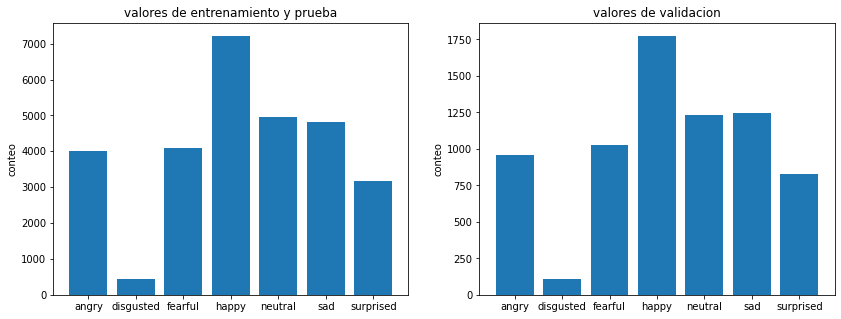

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.bar(clases, np.bincount(y))
ax1.set_title("valores de entrenamiento y prueba")
ax1.set_ylabel("conteo")

ax2.bar(clases, np.bincount(y_val))
ax2.set_title("valores de validacion")
ax2.set_ylabel("conteo")

plt.show()

El dataset está claramente desbalanceado sobre todo para la clases disguested, la cual tiene muy pocos ejemplos respecto al resto, y de la clase happy la cual tiene muchos más ejemplos que el resto, lo cual probablemente afecte el desempeño de la CNN.

Debido a que la clase "disgusted" tiene demasiado pocas imágenes, que ni duplicando todas las imágenes alcanzaría a estar balanceado, se decide eliminar esta clase, ya que se considera que con las demás clases se puede seguir caracterizando bien las emociones faciales, y también porque al tener tan pocas imágenes de esta clase afectara el desempeño general del modelo.

(ejemplo de imagen de la clase disgusted)

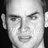

adicionalmente se balancearán las demás clases usando data augmentation.

In [ ]:
# eliminar categoria "disgusted"
X = X[ y != 1 ]
y = y[ y != 1 ]

X_val = X_val[ y_val != 1 ]
y_val = y_val[ y_val != 1 ]

for i in range(1, 6):
    y[ y == i+1 ] = i
    y_val[ y_val == i+1 ] = i

clases.remove("disgusted")

In [ ]:
# aumento de datos
def data_aug_balanceo(X, y, clases, seed = 1):
    fig, (org_axes, aug_axes) = plt.subplots(2, len(clases), figsize=(24,8))

    max_cls = np.max(np.bincount(y))    # clase con mas imagenes
    for cls in np.unique(y):
        org_axes[cls].set_title(clases[cls])

        img_generar = max_cls - y[ y == cls ].size  # imagenes a generar

        if img_generar > 0:
            rango = np.where(y == cls)[0]   # indices de todas las imagenes de la clase

            np.random.seed(seed)
            selected = np.random.choice(rango, size=img_generar)    # indices de las imagenes seleccionadas al azar que seran aumentadas
            imgs_selected = X[selected].copy()                      # imagenes seleccionadas

            # rotar imagenes
            imgs_augmented = np.array([tfa.image.rotate(imgs_selected[i], np.random.uniform(-45, 45, 1) * np.pi/180) for i in range(img_generar)])

            # brillo aleatorio
            imgs_augmented = tf.image.stateless_random_brightness(imgs_augmented, max_delta=0.35, seed=(seed, seed))

            # contraste aleatorio
            imgs_augmented = tf.image.stateless_random_contrast(imgs_augmented, 0.2, 0.5, seed=(seed, seed))

            # concatenar imagenes con el resto del dataset
            imgs_augmented = np.asarray(imgs_augmented)
            X = np.concatenate((X, imgs_augmented), axis=0)
            y = np.concatenate((y, [cls]*img_generar), axis=0)

            # mostrar imagenes originales y aumentadas
            org_axes[cls].imshow(imgs_selected[0], cmap="gray")
            aug_axes[cls].imshow(imgs_augmented[0], cmap="gray")

        else:
            # para la clase mayoritaria se muestra un recuadro negro
            org_axes[cls].imshow(np.zeros((48,48)), cmap="gray")
            aug_axes[cls].imshow(np.zeros((48,48)), cmap="gray")

    org_axes[0].set_ylabel("Original")
    aug_axes[0].set_ylabel("Modificada")

    plt.grid(False)
    plt.show()

    return X, y

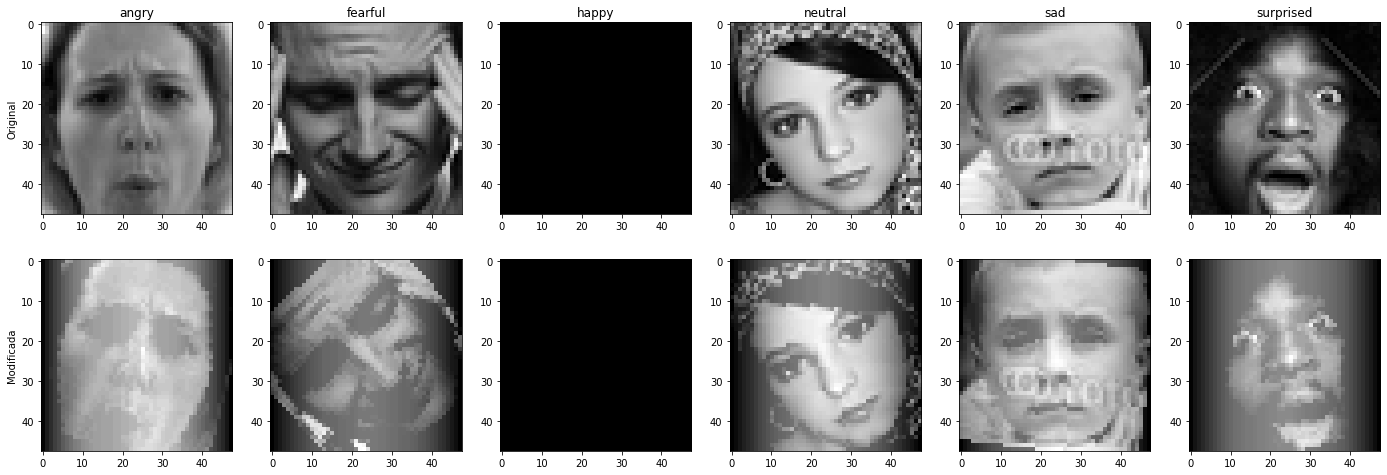

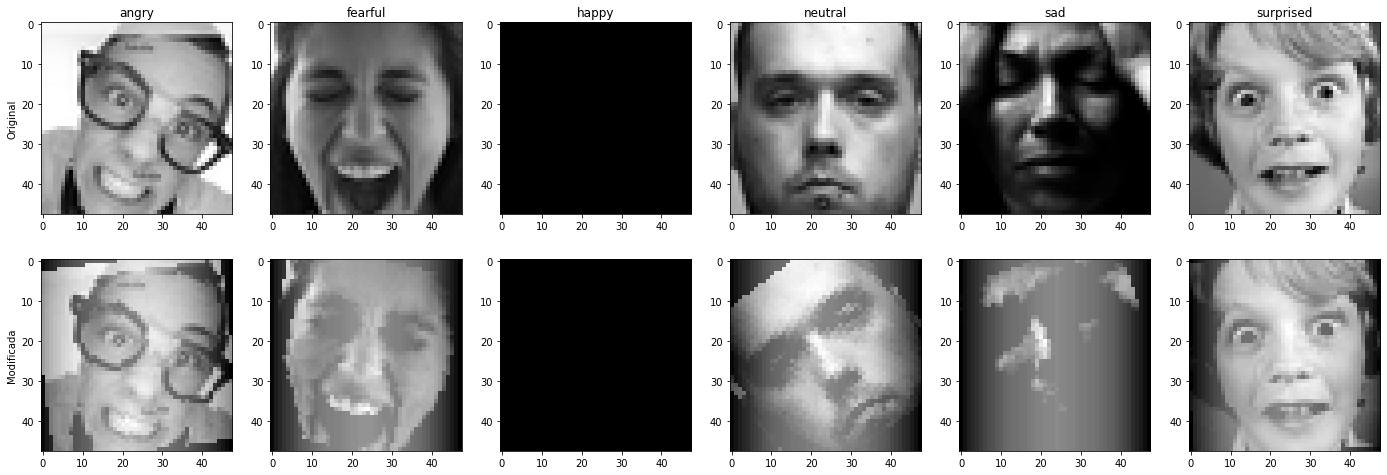

EJEMLPOS DE LAS TRANSFORMACIONES APLICADAS


In [ ]:
X, y = data_aug_balanceo(X, y, clases)

X_val, y_val = data_aug_balanceo(X_val, y_val, clases)

print("EJEMLPOS DE LAS TRANSFORMACIONES APLICADAS")

En la grafica se pueden ver ejemplos de como fueron modificadas algunas imagenes, para poder aumentar la cantidad de imagenes del dataset, cabe resaltar que la clase happy NO fue aumentada ya que era la clase que mas imagenes tenia, y las demas clases fueron aumentadas para alcanzar la cantidad de imagenes de la clase happy.

Otra cosa a resaltar es que durante el proceso de aumento de datos, se le aplicaron cambios al azar de brillo, contraste y rotacion a las imagenes, obteniendo asi mas variedad a partir de las imagenes iniciales, pero tambien, al ser estos cambios al azar, algunas imagenes tambien empeoraron de calidad durante el proceso de aumento de datos.

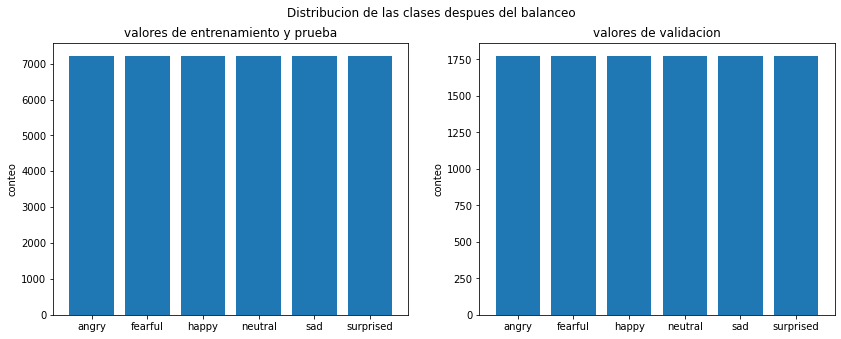

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.bar(clases, np.bincount(y))
ax1.set_title("valores de entrenamiento y prueba")
ax1.set_ylabel("conteo")

ax2.bar(clases, np.bincount(y_val))
ax2.set_title("valores de validacion")
ax2.set_ylabel("conteo")

plt.suptitle("Distribucion de las clases despues del balanceo")
plt.show()

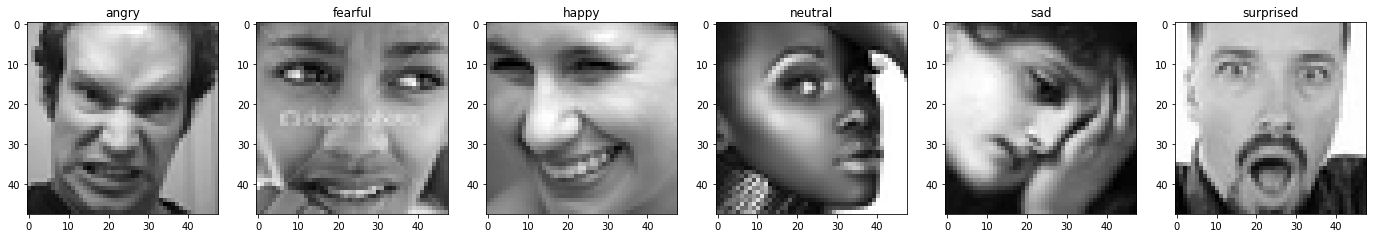

In [ ]:
# ejemplo de imagenes
fig, axes = plt.subplots(1,6, figsize=(24,24))

for i in range(len(clases)):
    axes[i].imshow(X[ y == i ][13], cmap="gray")
    axes[i].set_title(clases[i])


plt.grid(False)
plt.show()

- Inicialmente se tenía un dataset de 35.903 imágenes en blanco y negro de tamaño 48x48 pixeles
- Se eliminaron 563 imágenes correspondientes a la clase "disgusted"
- Se balancearon las clases usando data augmentation (variando la iluminación, contraste y rotación), por lo que finalmente se obtuvo un dataset con 53.934 imágenes.

Se codificaron las clases de la siguiente forma:

|Clase|Codigo|
|-----|------|
|angry|0|
|fearful|1|
|happy|2|
|neutral|3|
|sad|4|
|surprised|5|

(link del dataset: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer)

In [ ]:
# normalizar imagenes a valores entre [0,1]
X = X / 255
X_val = X_val / 255

In [ ]:
# dividir los datos en entrenamiento y validacion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

In [ ]:
func_act = "relu"

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), input_shape=(48,48,1), activation=func_act),
    # tk.keras.layers.MaxPool2D((2,2), strides=(2,2)),

    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation=func_act),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2), strides=(2,2)),
    tf.keras.layers.Dropout(0.20),

    tf.keras.layers.Conv2D(80, kernel_size=(3,3), activation=func_act),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2), strides=(2,2)),
    tf.keras.layers.Dropout(0.20),

    tf.keras.layers.Conv2D(100, kernel_size=(3,3), activation=func_act),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2), strides=(2,2)),
    tf.keras.layers.Dropout(0.20),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150, activation=func_act),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation=func_act),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation=func_act),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(clases), activation="softmax")
])

model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 80)       

In [ ]:
# early stopping para cuando no mejora mas el modelo
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6, restore_best_weights=True)
# mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history_RN = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=60, callbacks=[es])

Epoch 1/60
947/947 [==============================] - 11s 11ms/step - loss: 1.6363 - accuracy: 0.3044 - val_loss: 1.8546 - val_accuracy: 0.2521
Epoch 2/60
947/947 [==============================] - 10s 10ms/step - loss: 1.4299 - accuracy: 0.3972 - val_loss: 1.7392 - val_accuracy: 0.3644
Epoch 3/60
947/947 [==============================] - 12s 12ms/step - loss: 1.2866 - accuracy: 0.4701 - val_loss: 1.5136 - val_accuracy: 0.3707
Epoch 4/60
947/947 [==============================] - 10s 11ms/step - loss: 1.1808 - accuracy: 0.5221 - val_loss: 1.3382 - val_accuracy: 0.5099
Epoch 5/60
947/947 [==============================] - 10s 10ms/step - loss: 1.1080 - accuracy: 0.5587 - val_loss: 1.1090 - val_accuracy: 0.5805
Epoch 6/60
947/947 [==============================] - 10s 10ms/step - loss: 1.0680 - accuracy: 0.5802 - val_loss: 1.1651 - val_accuracy: 0.5597
Epoch 7/60
947/947 [==============================] - 10s 10ms/step - loss: 1.0163 - accuracy: 0.6042 - val_loss: 1.1988 - val_accuracy:

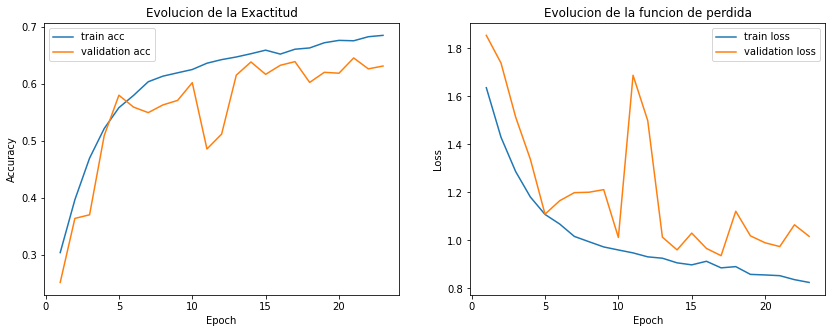

In [ ]:
# graficas de la evolucion del acurracy y loss
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

history = history_RN.history
epochs = range(1, len(history["accuracy"]) + 1)

# plot acurracy
ax1.plot(epochs, history["accuracy"], label="train acc")
ax1.plot(epochs, history["val_accuracy"], label="validation acc")

ax1.legend()
ax1.set_title("Evolucion de la Exactitud")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")


# plot loss
ax2.plot(epochs, history["loss"], label="train loss")
ax2.plot(epochs, history["val_loss"], label="validation loss")

ax2.legend()
ax2.set_title("Evolucion de la funcion de perdida")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")

plt.show()

# Matrices de confusion y metricas

406/406 [==============================] - 1s 3ms/step


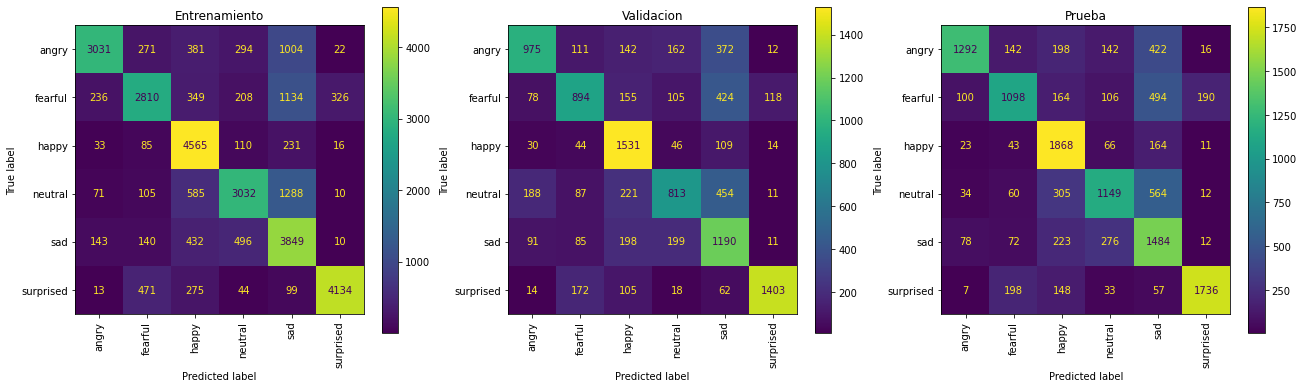


ENTRENAMIENTO:

              precision    recall  f1-score   support

           0       0.86      0.61      0.71      5003
           1       0.72      0.56      0.63      5063
           2       0.69      0.91      0.79      5040
           3       0.72      0.60      0.65      5091
           4       0.51      0.76      0.61      5070
           5       0.92      0.82      0.87      5036

    accuracy                           0.71     30303
   macro avg       0.74      0.71      0.71     30303
weighted avg       0.74      0.71      0.71     30303


VALIDACION:

              precision    recall  f1-score   support

           0       0.71      0.55      0.62      1774
           1       0.64      0.50      0.56      1774
           2       0.65      0.86      0.74      1774
           3       0.61      0.46      0.52      1774
           4       0.46      0.67      0.54      1774
           5       0.89      0.79      0.84      1774

    accuracy                           0.64   

In [ ]:
# metricas
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(22,6))

# train
y_pred = np.argmax(model.predict(X_train), axis=1)

train_report = classification_report(y_train, y_pred)

cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
disp.plot(xticks_rotation='vertical', values_format='d', ax=ax1)
ax1.set_title("Entrenamiento")

# valid
y_pred = np.argmax(model.predict(X_val), axis=1)

val_report = classification_report(y_val, y_pred)

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
disp.plot(xticks_rotation='vertical', values_format='d', ax=ax2)
ax2.set_title("Validacion")

# test
y_pred = np.argmax(model.predict(X_test), axis=1)

test_report = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
disp.plot(xticks_rotation='vertical', values_format='d', ax=ax3)
ax3.set_title("Prueba")

plt.show()

print("\nENTRENAMIENTO:\n")
print(train_report)

print("\nVALIDACION:\n")
print(val_report)

print("\nPRUEBA:\n")
print(test_report)

# Transfer Learning

In [ ]:
# convertir imagenes de grayscale a RGB ya que el modelo preentrenado lo requiere asi
X_train2 = tf.image.grayscale_to_rgb(tf.constant(np.expand_dims(X_train*255, axis=3)))
X_val2 = tf.image.grayscale_to_rgb(tf.constant(np.expand_dims(X_val*255, axis=3)))
X_test2 = tf.image.grayscale_to_rgb(tf.constant(np.expand_dims(X_test*255, axis=3)))

print(
    X_train2.shape,
    X_val2.shape,
    X_test2.shape,
    sep="\n"
)

# preprocess para compatibilidad con ResNet50
X_train2 = preprocess_input(X_train2)
X_val2 = preprocess_input(X_val2)
X_test2 = preprocess_input(X_test2)

(30303, 48, 48, 3)
(10644, 48, 48, 3)
(12987, 48, 48, 3)


In [ ]:
# cargar modelo preentrenado
TFmodel = ResNet50(include_top=False, weights='imagenet', input_shape=(48,48,3))

# Se impide que las capas preentrenadas sean entrenables.
for layer in TFmodel.layers:
    layer.trainable = False

x = TFmodel.output

x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(100, activation="relu")(x)
output = tf.keras.layers.Dense(len(clases), activation="softmax")(x)

TFmodel = Model(inputs=TFmodel.input, outputs=output)

TFmodel.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

TFmodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [ ]:
# early stopping para cuando no mejora mas el modelo
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6, restore_best_weights=True)
# mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history_RN = TFmodel.fit(X_train2, y_train, validation_data=(X_val2, y_val), epochs=60, callbacks=[es])

Epoch 1/60
947/947 [==============================] - 26s 23ms/step - loss: 1.7182 - accuracy: 0.3703 - val_loss: 1.5889 - val_accuracy: 0.4025
Epoch 2/60
947/947 [==============================] - 20s 21ms/step - loss: 1.4820 - accuracy: 0.4425 - val_loss: 1.6005 - val_accuracy: 0.4105
Epoch 3/60
947/947 [==============================] - 19s 21ms/step - loss: 1.4221 - accuracy: 0.4613 - val_loss: 1.6029 - val_accuracy: 0.4159
Epoch 4/60
947/947 [==============================] - 19s 20ms/step - loss: 1.3936 - accuracy: 0.4758 - val_loss: 1.6356 - val_accuracy: 0.4053
Epoch 5/60
947/947 [==============================] - 19s 20ms/step - loss: 1.3686 - accuracy: 0.4860 - val_loss: 1.6011 - val_accuracy: 0.4164
Epoch 6/60
947/947 [==============================] - 20s 21ms/step - loss: 1.3486 - accuracy: 0.4958 - val_loss: 1.6083 - val_accuracy: 0.4218
Epoch 7/60
947/947 [==============================] - 20s 21ms/step - loss: 1.3420 - accuracy: 0.5014 - val_loss: 1.6194 - val_accuracy:

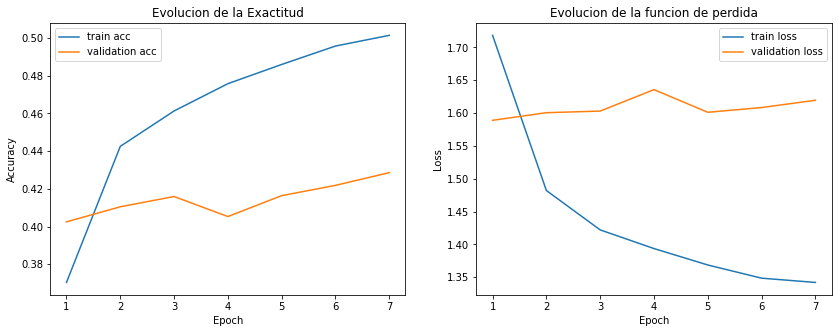

In [ ]:
# graficas de la evolucion del acurracy y loss
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

history = history_RN.history
epochs = range(1, len(history["accuracy"]) + 1)

# plot acurracy
ax1.plot(epochs, history["accuracy"], label="train acc")
ax1.plot(epochs, history["val_accuracy"], label="validation acc")

ax1.legend()
ax1.set_title("Evolucion de la Exactitud")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")


# plot loss
ax2.plot(epochs, history["loss"], label="train loss")
ax2.plot(epochs, history["val_loss"], label="validation loss")

ax2.legend()
ax2.set_title("Evolucion de la funcion de perdida")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")

plt.show()

406/406 [==============================] - 5s 13ms/step


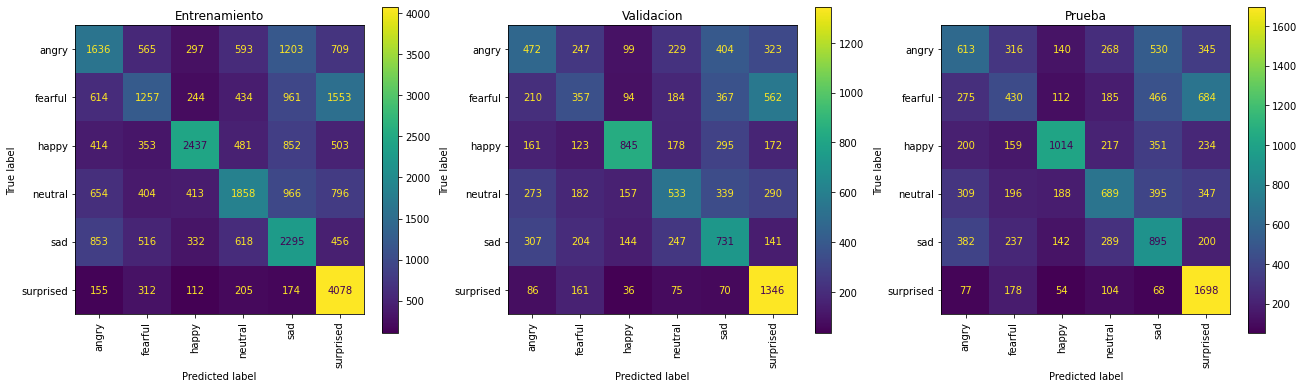


ENTRENAMIENTO:

              precision    recall  f1-score   support

           0       0.38      0.33      0.35      5003
           1       0.37      0.25      0.30      5063
           2       0.64      0.48      0.55      5040
           3       0.44      0.36      0.40      5091
           4       0.36      0.45      0.40      5070
           5       0.50      0.81      0.62      5036

    accuracy                           0.45     30303
   macro avg       0.45      0.45      0.44     30303
weighted avg       0.45      0.45      0.44     30303


VALIDACION:

              precision    recall  f1-score   support

           0       0.31      0.27      0.29      1774
           1       0.28      0.20      0.23      1774
           2       0.61      0.48      0.54      1774
           3       0.37      0.30      0.33      1774
           4       0.33      0.41      0.37      1774
           5       0.47      0.76      0.58      1774

    accuracy                           0.40   

In [ ]:
# metricas
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(22,6))

# train
y_pred = np.argmax(TFmodel.predict(X_train2), axis=1)

train_report = classification_report(y_train, y_pred)

cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
disp.plot(xticks_rotation='vertical', values_format='d', ax=ax1)
ax1.set_title("Entrenamiento")

# valid
y_pred = np.argmax(TFmodel.predict(X_val2), axis=1)

val_report = classification_report(y_val, y_pred)

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
disp.plot(xticks_rotation='vertical', values_format='d', ax=ax2)
ax2.set_title("Validacion")

# test
y_pred = np.argmax(TFmodel.predict(X_test2), axis=1)

test_report = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
disp.plot(xticks_rotation='vertical', values_format='d', ax=ax3)
ax3.set_title("Prueba")

plt.show()

print("\nENTRENAMIENTO:\n")
print(train_report)

print("\nVALIDACION:\n")
print(val_report)

print("\nPRUEBA:\n")
print(test_report)

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as preprocess_input_mobilenet

# convertir imagenes de grayscale a RGB ya que el modelo preentrenado lo requiere asi
X_train3 = tf.image.grayscale_to_rgb(tf.constant(np.expand_dims(X_train*255, axis=3)))
X_val3 = tf.image.grayscale_to_rgb(tf.constant(np.expand_dims(X_val*255, axis=3)))
X_test3 = tf.image.grayscale_to_rgb(tf.constant(np.expand_dims(X_test*255, axis=3)))

print(
    X_train3.shape,
    X_val3.shape,
    X_test3.shape,
    sep="\n"
)

# preprocess para compatibilidad con MobileNetV2
X_train3 = preprocess_input_mobilenet(X_train3)
X_val3 = preprocess_input_mobilenet(X_val3)
X_test3 = preprocess_input_mobilenet(X_test3)


(30303, 48, 48, 3)
(10644, 48, 48, 3)
(12987, 48, 48, 3)


In [ ]:
# cargar modelo preentrenado
TFmodel2 = MobileNetV2(include_top=False, weights='imagenet', input_shape=(48,48,3))

# Se impide que las capas preentrenadas sean entrenables.
for layer in TFmodel2.layers:
    layer.trainable = False

x = TFmodel2.output

x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(100, activation="relu")(x)
output = tf.keras.layers.Dense(len(clases), activation="softmax")(x)

TFmodel2 = Model(inputs=TFmodel2.input, outputs=output)

TFmodel2.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

TFmodel2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 24, 24, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 24, 24, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 24, 24, 32)   0           ['bn_Conv1[0][0]']               
                                                                                            

In [ ]:
# early stopping para cuando no mejora mas el modelo
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6, restore_best_weights=True)
# mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history_RN = TFmodel2.fit(X_train3, y_train, validation_data=(X_val3, y_val), epochs=60, callbacks=[es])

Epoch 1/60
947/947 [==============================] - 14s 12ms/step - loss: 1.6575 - accuracy: 0.3453 - val_loss: 1.6069 - val_accuracy: 0.3623
Epoch 2/60
947/947 [==============================] - 10s 11ms/step - loss: 1.4977 - accuracy: 0.4061 - val_loss: 1.5775 - val_accuracy: 0.3750
Epoch 3/60
947/947 [==============================] - 10s 10ms/step - loss: 1.4626 - accuracy: 0.4228 - val_loss: 1.5717 - val_accuracy: 0.3775
Epoch 4/60
947/947 [==============================] - 10s 11ms/step - loss: 1.4410 - accuracy: 0.4327 - val_loss: 1.6445 - val_accuracy: 0.3621
Epoch 5/60
947/947 [==============================] - 10s 10ms/step - loss: 1.4295 - accuracy: 0.4340 - val_loss: 1.6198 - val_accuracy: 0.3708
Epoch 6/60
947/947 [==============================] - 11s 11ms/step - loss: 1.4243 - accuracy: 0.4362 - val_loss: 1.6650 - val_accuracy: 0.3597
Epoch 7/60
947/947 [==============================] - 10s 10ms/step - loss: 1.4246 - accuracy: 0.4378 - val_loss: 1.6244 - val_accuracy:

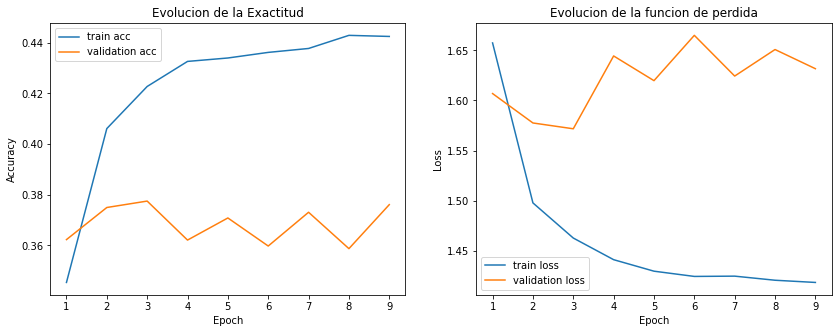

In [ ]:
# graficas de la evolucion del acurracy y loss
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

history = history_RN.history
epochs = range(1, len(history["accuracy"]) + 1)

# plot acurracy
ax1.plot(epochs, history["accuracy"], label="train acc")
ax1.plot(epochs, history["val_accuracy"], label="validation acc")

ax1.legend()
ax1.set_title("Evolucion de la Exactitud")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")


# plot loss
ax2.plot(epochs, history["loss"], label="train loss")
ax2.plot(epochs, history["val_loss"], label="validation loss")

ax2.legend()
ax2.set_title("Evolucion de la funcion de perdida")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")

plt.show()

406/406 [==============================] - 3s 7ms/step


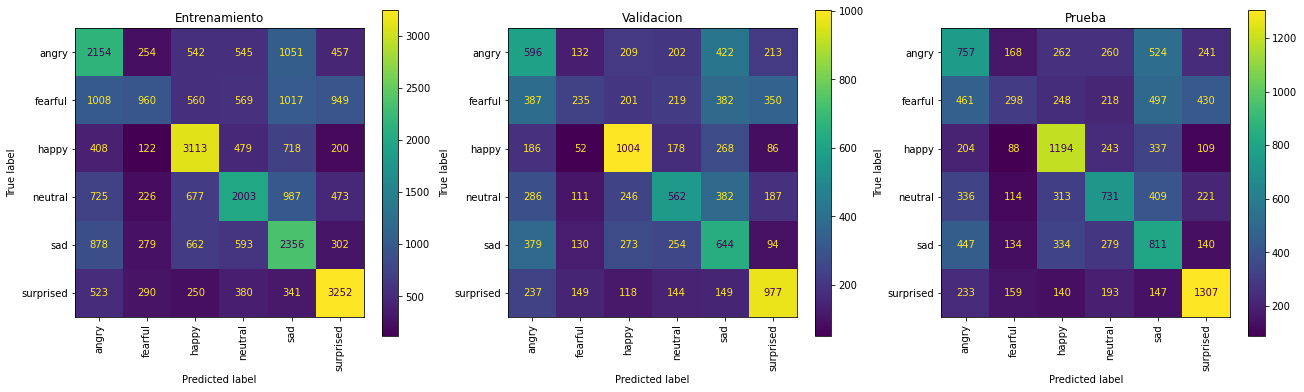


ENTRENAMIENTO:

              precision    recall  f1-score   support

           0       0.38      0.43      0.40      5003
           1       0.45      0.19      0.27      5063
           2       0.54      0.62      0.57      5040
           3       0.44      0.39      0.41      5091
           4       0.36      0.46      0.41      5070
           5       0.58      0.65      0.61      5036

    accuracy                           0.46     30303
   macro avg       0.46      0.46      0.45     30303
weighted avg       0.46      0.46      0.45     30303


VALIDACION:

              precision    recall  f1-score   support

           0       0.29      0.34      0.31      1774
           1       0.29      0.13      0.18      1774
           2       0.49      0.57      0.52      1774
           3       0.36      0.32      0.34      1774
           4       0.29      0.36      0.32      1774
           5       0.51      0.55      0.53      1774

    accuracy                           0.38   

In [ ]:
# metricas
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(22,6))

# train
y_pred = np.argmax(TFmodel2.predict(X_train3), axis=1)

train_report = classification_report(y_train, y_pred)

cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
disp.plot(xticks_rotation='vertical', values_format='d', ax=ax1)
ax1.set_title("Entrenamiento")

# valid
y_pred = np.argmax(TFmodel2.predict(X_val3), axis=1)

val_report = classification_report(y_val, y_pred)

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
disp.plot(xticks_rotation='vertical', values_format='d', ax=ax2)
ax2.set_title("Validacion")

# test
y_pred = np.argmax(TFmodel2.predict(X_test3), axis=1)

test_report = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
disp.plot(xticks_rotation='vertical', values_format='d', ax=ax3)
ax3.set_title("Prueba")

plt.show()

print("\nENTRENAMIENTO:\n")
print(train_report)

print("\nVALIDACION:\n")
print(val_report)

print("\nPRUEBA:\n")
print(test_report)

In [ ]:
def plot_imagen_classification(modelo, imagen, y_true):
    global clases

    predictions = modelo.predict(imagen)
    predicted_class = np.argmax(predictions)
    
    fig, (img_ax, prob_ax) = plt.subplots(1, 2, figsize=(10,5))

    colors = ["blue"]*len(clases)
    colors[y_true] = "green"
    colors[predicted_class] = "red"
    
    img_ax.imshow(imagen[0], cmap="gray")

    prob_ax.bar(clases, predictions[0], label="otras clases", color="blue")
    prob_ax.bar(clases[y_true], predictions[0, y_true], label=f"verdadera ({clases[y_true]})", color="green")
    prob_ax.bar(clases[predicted_class], predictions[0, predicted_class], label=f"predicha ({clases[predicted_class]})", color="red")

    prob_ax.legend()
    prob_ax.set_ylabel("probabilidad")
    plt.show()

1/1 [==============================] - 0s 56ms/step


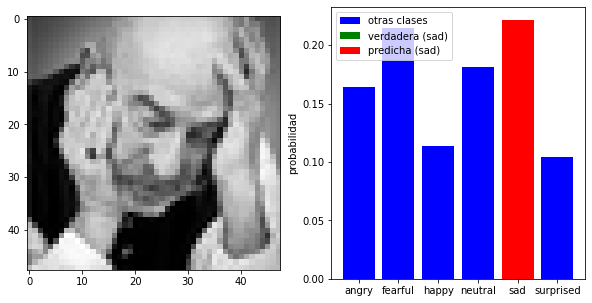

1/1 [==============================] - 0s 19ms/step


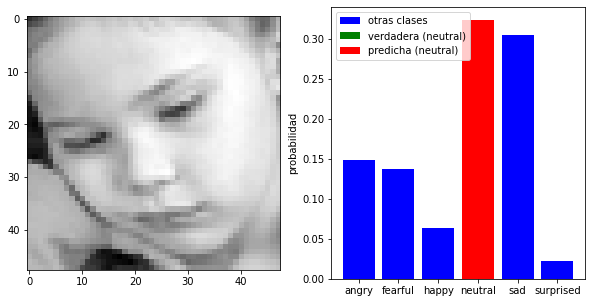

1/1 [==============================] - 0s 16ms/step


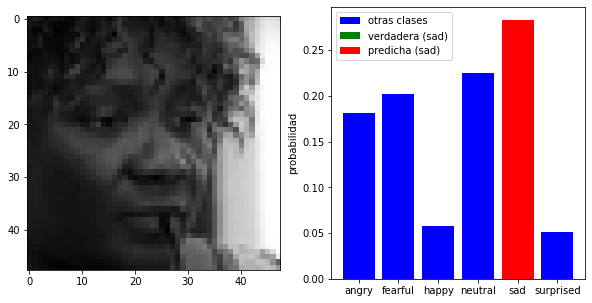

In [ ]:
plot_imagen_classification(model, np.expand_dims(X_val[ y_val == 4 ][28], axis=0), 4)
plot_imagen_classification(model, np.expand_dims(X[ y == 3 ][14], axis=0), 3)
plot_imagen_classification(model, np.expand_dims(X[ y == 4 ][123], axis=0), 4)

## Conclusiones

- Se realizo una arquitectura propia de una CNN la cual no presenta un overfitting grave, sin embargo no alcanza unos niveles de exactitud deseados (probablemente por lo que se explica en el siguiente punto).
- la clase que mejor resultado fue happy sin necesidad de data augmetation, posiblemente debido a que era la categoría con más imágenes y al no ser necesario aumentar la cantidad de imágenes, no se empeoro la calidad de estas.
- De las matrices de confusión y los reportes de clasificación se encontró que, es muy común que el clasificador confunda las imágenes de las categorías: angry, fearful, happy, neutral con la categoría sad, esto debido a que si se observan las imágenes de la categoría sad, se puede ver que muchas de estas se parecen con las de otras categorías, o incluso hay imágenes que uno creería que no deberían de estar en la categoría que están, lo que afecta el desempeño del modelo, a continuación se muestran ejemplos de lo anterior dicho.

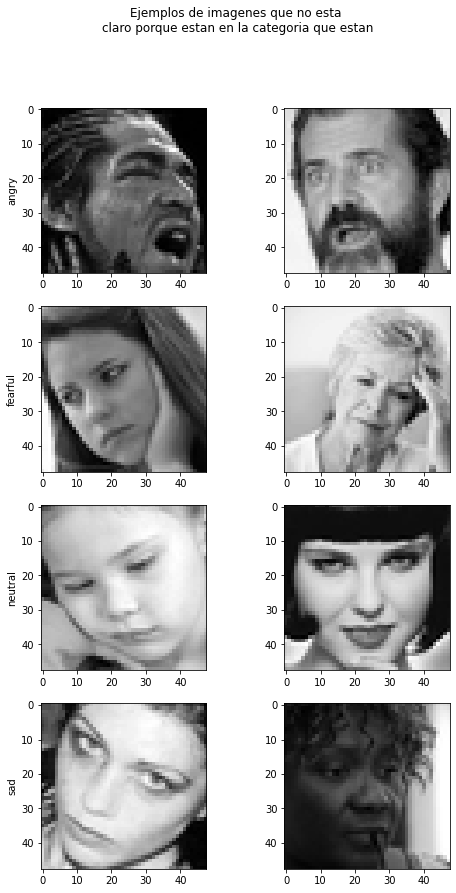

- también se muestran algunas imágenes como las que se mencionan en el punto anterior, las cuales son ambiguas respecto a la emoción que dice el dataset que representa, se ve que el clasificador tiene una gran incertidumbre para estas imágenes, siendo especialmente indeciso con las clases sad y neutral. De esto se concluye que la calidad del dataset no es la mejor, lo que influye en el rendimiento de los modelos

- Por último se usaron dos CNN preentrenadas, ResNet50 y MobileNetV2, con el propósito de hacer transfer learning. Ambas redes estaban preentrenadas en el dataset ImageNet, con ambas redes se realizó el procedimiento de eliminar las capas superiores de clasificación y reemplazarla por una que fuera útil en nuestro proyecto. Finalmente, los resultados obtenidos en ambas redes fueron muy pobres, seguramente debido a lo mencionado en los puntos anteriores, por lo que, para un proyecto futuro de reconocimiento de emociones faciales, se recomienda usar un dataset de mejor calidad.

prueba con imagen del profesor, como cierre del curso
1/1 [==============================] - 1s 895ms/step


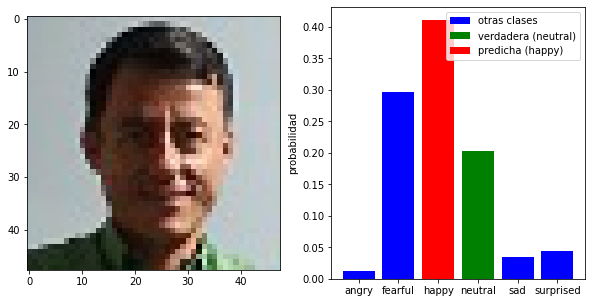

In [ ]:
path = "/content/drive/Shareddrives/Trabajos IA/Proyecto4/"

img = Image.open(path + "demetrio.jpg")
img = np.asarray(img)

# img = tf.image.rgb_to_grayscale(np.expand_dims(img, axis=0))
# img = np.squeeze(img, axis=3)

print("prueba con imagen del profesor, como cierre del curso")
plot_imagen_classification(TFmodel, np.expand_dims(img, axis=0), 3)